# Ejercicio 1

In [25]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pylab as plt
from urllib.request import urlopen
from os import listdir
from collections import defaultdict

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]

In [8]:
# Carga de datos.

fnlit = "Datos/yeast_LIT.txt"
fnbin = "Datos/yeast_Y2H.txt"
fnprot = "Datos/yeast_AP-MS.txt"

# Obtenida de literatura
red_lit = [nx.read_edgelist(fnlit),fnlit]
# Interacciones binarias
red_bin = [nx.read_edgelist(fnbin),fnbin]
# Copertenencia
red_prot = [nx.read_edgelist(fnprot),fnprot]

#### Funciones

In [34]:
# Función que toma el nombre de un archivo txt, lo abre, e intenta determinar si el grafo es dirigido. Si no encuentra
# evidencia de que el grafo es dirigido (i.e. links repetidos), reporta que no lo es. Desde ya que el grafo podría ser
# dirigido de todas formas. Además, si se encuentra con un loop, envía un warning avisando que no es simple el grafo.

def esDirigido(file):

    with open(file,"r") as f:
        vecinos = defaultdict(set)
        i = 0
        s = True
        for line in f:
            a = line.rstrip('\n').split('\t')
            v = a[0]
            w = a[1]
            vecinos[v].add(w)
            i += 1
            if v in vecinos[w] and  w!=v:
                return True
            elif v == w and s:
                print("Warning:", file, "no es un grafo simple.")
                s = False
            
        return False

In [36]:
# Función que toma una red y devuelve un diccionario con algunas de sus propiedades.

def propiedades(red):
    # Diccionario a retornar
    caract = {}
    # NumPy Array con los grados de todos los nodos
    d = np.array([grado for nodo, grado in red[0].degree()])
    
    caract['Nodos'] = red[0].number_of_nodes()
    caract['Enlaces'] = red[0].number_of_edges()
    caract['Dirigida'] = esDirigido(red[1])
    caract['Grado max'] = d.max()
    caract['Grado min'] = d.min()
    caract['Grado promedio'] = d.mean()
    caract['Densidad'] = caract['Enlaces'] / ((caract['Nodos']) * (caract['Nodos'] - 1) / 2)
    caract['Clustering medio'] = nx.average_clustering(red[0])
    caract['Transitividad'] = nx.transitivity(red[0])
    comps = list(nx.connected_component_subgraphs(red[0]))
    diams = np.array([])
    for comp in comps:
        diams = np.append(diams, nx.diameter(comp))
    caract['Diámetro'] = int(diams.max())
        
    return caract

## Resolución

Abajo vemos la comparación gráfica de las tres redes (ítem a).

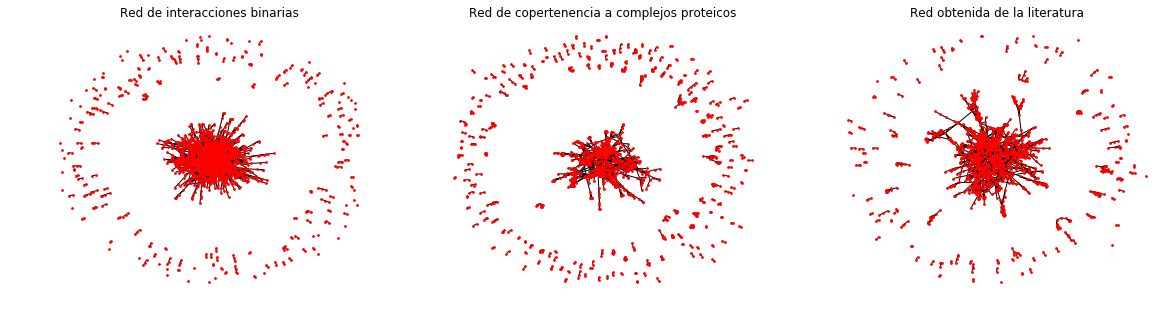

In [31]:
plt.subplot(131)
plt.title("Red de interacciones binarias")
nx.draw(red_bin[0], node_size=3)
plt.subplot(132)
plt.title("Red de copertenencia a complejos proteicos")
nx.draw(red_prot[0], node_size=3)
plt.subplot(133)
plt.title("Red obtenida de la literatura")
nx.draw(red_lit[0], node_size=3)
plt.show()

Para caracterizar mejor a estas tres redes, es útil conocer algunas de sus propiedades (ítem b):

In [37]:
redes = [red_prot, red_bin, red_lit]
props = []

for red in redes:
    props.append(propiedades(red))
sRed = ['Red Proteica','Red Binaria', 'Red Literatura']
pd.DataFrame(props, index=sRed)

,Clustering medio,Densidad,Desv. estándar del grado,Dirigida,Diámetro,Enlaces,Grado max,Grado min,Grado promedio,Nodos,Transitividad
Red Proteica,0.554636,0.006899,16.227788,False,15,9070,127,1,11.183724,1622,0.618590
Red Binaria,0.046194,0.001440,4.881923,False,14,2930,91,1,2.903865,2018,0.023614
Red Literatura,0.292492,0.002481,4.211354,False,19,2925,40,1,3.808594,1536,0.346193


#### Relevamiento del AP-MS

Al final del ejercicio 4 se ve claramente que la red AP-MS, que nosotros nombramos red protéica, presenta un carácter asortativo. Es decir, los nodos de grado alto suelen estar enlazados con nodos de grado alto.

Si nos preguntamos cómo se relevaron los vínculos entre proteínas en la red de copertenencia AP-MS, la asortatividad puede ser un indicador importante. Suponemos que hay dos posibles maneras de relevar los datos: una es pensando que en los complejos de proteínas todas están conectadas con todas, y la segunda es pensando que todas las proteínas "presa" están conectadas a una única proteína "carnada" (esto tiene que ver con la manera de obtener experimentalmente los complejos). En el primer caso, es esperable hallar un alto grado de asortatividad (en cada complejo nuevo los nodos tendrán todos el mismo grado), mientras que en el segundo un alto grado de disasortatividad (las carnadas de grado alto conectadas a presas de grado bajo).

Desde ya que podría ser posible que la propia estructura real de la red, cuyo comportamiento no conocemos, produzca la inversión de este fenómeno en alguno de los dos hipotéticos casos, pero parece muy contraintuitivo y extremadamente improbable.

Por lo tanto, debido a la alta asortatividad de la red, deducimos que la red de copertenencia AP-MS fue relevada pensando a los complejos como un conjunto de nodos, todos interconectados entre sí.